# Initial Notebook - Formula 1 Data Analysis

In this notebook, we aim to investigate the available data and understand possible patterns. As a result, we want to create a foundation for making modelling decisions and assumptions.

First, needed packages are imported.

In [2]:
pip install colorcet

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

import seaborn as sns
import colorcet as cc
import plotly.express as px
from IPython.display import Image

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## 1. Data Load

All relevant data is loaded into dataframes. To begin with, we merge the status data (contains status regarding withdrawel, retirement, finishing) onto the results data. We also convert the date data to datetime values.

Some of the data is from the very beginning of Formula 1 in 1950. But some of the more detailed data, e.g. laptimes, has only been collected since 1996.

In [9]:
df_laptimes = pd.read_csv('Data\lap_times.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Data\\lap_times.csv'

In [6]:
df_laptimes = pd.read_csv(r'Data/lap_times.csv')
df_constructors = pd.read_csv('Data\constructors.csv')
df_drivers = pd.read_csv('Data\drivers.csv')
df_races = pd.read_csv('Data\races.csv')
df_circuits = pd.read_csv('Data\circuits.csv')
df_driverstandings = pd.read_csv('Data\driver_standings.csv')
df_constructorstandings = pd.read_csv('Data\constructor_standings.csv')
df_constructorresults = pd.read_csv('Data\constructor_results.csv')
df_results = pd.read_csv('Data\results.csv')
df_status = pd.read_csv('Data\status.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Data/lap_times.csv'

In [10]:
#add status to results (to be able to filter out all finished race results)
df_results = df_results.merge(df_status, on='statusId', how='inner',suffixes=('_result', '_status'))

#change dates to datetime
df_races.date = pd.to_datetime(df_races.date)

## 2. Circuit Map

As a beginning, we thought it would be interesting to show, where in the world Formula 1 races has taken place across the years. Different teams prefer different circuits, and different drivers may have preferences for the kind of weather they drive best in. This is all affected by where in the world a race takes place.

Text(0.5, 1.0, 'F1 Circuit Locations')

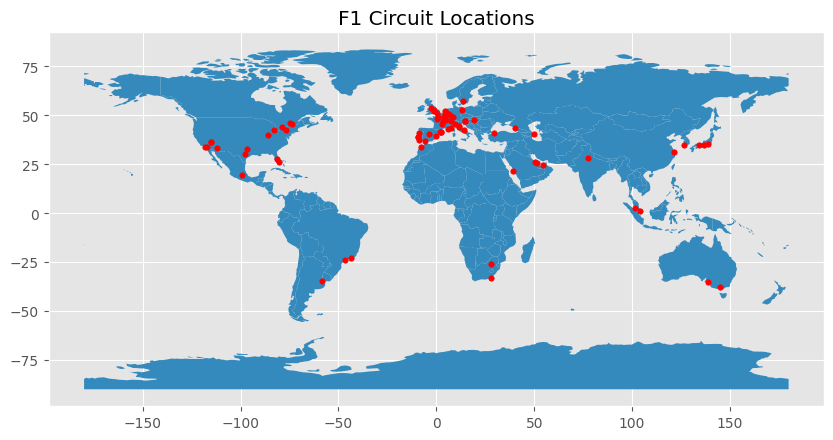

In [11]:
#create geographical points
geometry = [Point(xy) for xy in zip(df_circuits['lng'], df_circuits['lat'])]
gdf = GeoDataFrame(df_circuits, geometry=geometry)   

#plot points on a simple map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
plt.title('F1 Circuit Locations')

There are many circuits in Europe - this is where Formula 1 originated. But throughout its history, races have expanded to the rest of the world.

## 3. Development in Laptimes

As Formula 1 is a sport that has existed for so many years, the race cars have evolved as technology has evolved. Race cars have also changed due to rule changes. Keeping this in mind, we are interested in seeing how laptimes have evolved over time.

In [12]:
#merge laptimes with race data
df = df_laptimes.merge(df_races, on='raceId', how='inner',suffixes=('_laptime', '_race'))
df.date = pd.to_datetime(df.date)

Text(0, 0.5, 'Milliseconds')

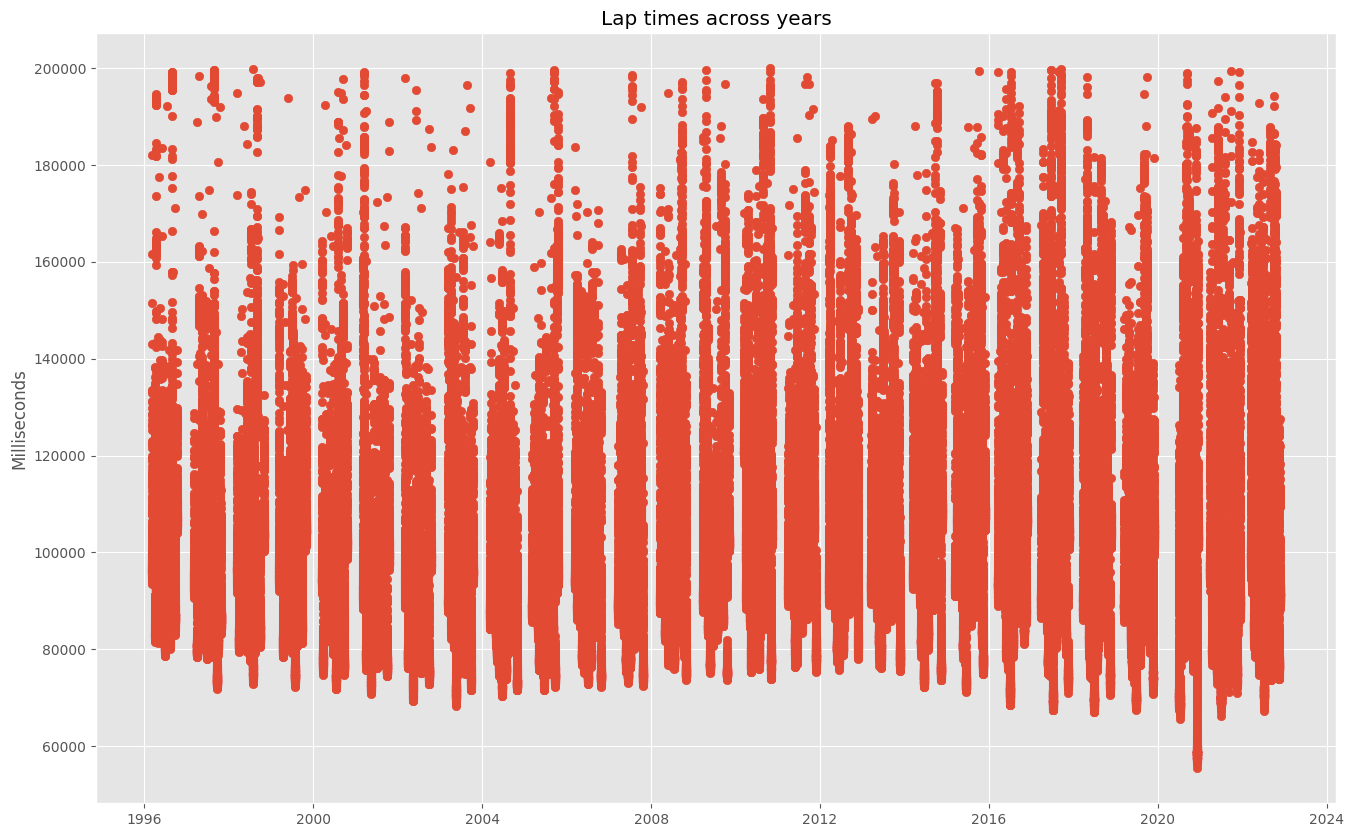

In [13]:
#plot laptimes in reasonable interval as function of time
laptimes = df[df.milliseconds<200000]
plt.scatter(laptimes.date,laptimes.milliseconds)
plt.title('Lap times across years')
plt.ylabel('Milliseconds')

It can be observed that the lap times has changed throughout history. The plot indicates a cyclic behavior where lap times become quicker, then slower and vice versa. A possible explanation for the cyclic behavior in lap times could be changes in regulations. The regulations determine how the race cars can be built - i.e. their size and weight etc. Whenever a major rule change is introduced, each constructor has to spend time perfecting its design to become as quick as possible. Among other things, this entails creating the best design in terms of aerodynamics. Therefore, when a new car design is introduced, the lap times will be slower compared to when a car design has existed for years.

In the plot it can even be observed that some races were delayed or cancelled in the beginning of 2020 due to COVID-19.

Let's zoom in on a single circuit, the Australian Grand Prix, and examine the lap times. Here, the observations align with the global observations.

Text(0, 0.5, 'Milliseconds')

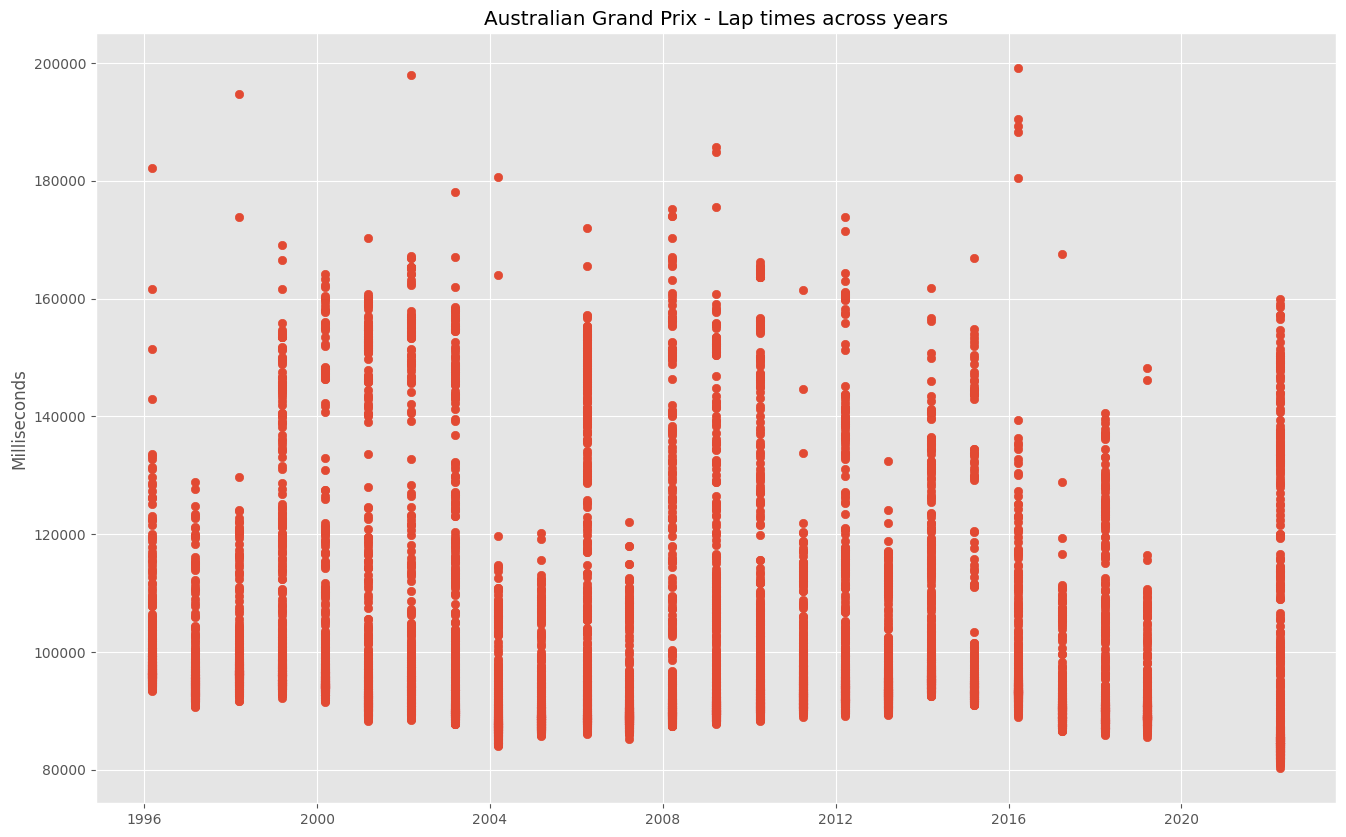

In [14]:
#plot Australian subset of laptimes in reasonable interval as function of time
df_aus = df[df.name=='Australian Grand Prix']
aus = df_aus[df_aus.milliseconds<200000]
plt.scatter(aus.date,aus.milliseconds)
plt.title('Australian Grand Prix - Lap times across years')
plt.ylabel('Milliseconds')

## 4. Race Duration

The goal of this project will be to either predict race results through a regression or through a classification. For either case, it is interesting to examine how race durations have changed over time. The driver with the lowest race duration will win, and depending on the specific race circuit, race durations will vary. Let's take a look at the race durations observed in the data set. We are only interested in race duraitons of the drivers who have finished the race and not any drivers who withdrew in the middle of the race.

In [15]:
#join finished results with raceId
df_racedur = df_results[df_results.status == 'Finished'].merge(df_races, on='raceId', how='inner',suffixes=('_result', '_race'))
#remove empty fields and convert to integers
df_racedur = df_racedur[df_racedur.milliseconds != '\\N']
df_racedur['milliseconds'] = df_racedur.milliseconds.astype('int64')

Text(0, 0.5, 'Milliseconds')

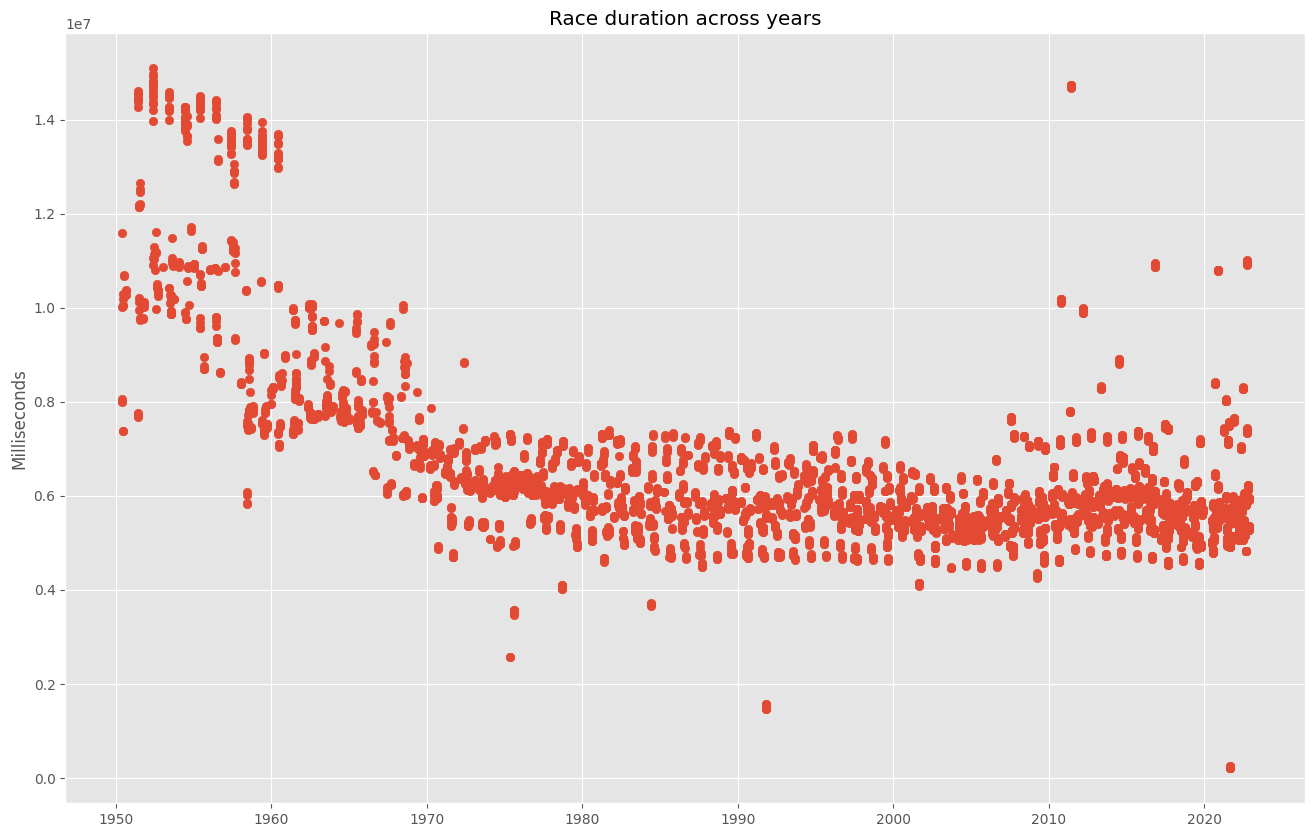

In [16]:
#plot race duration across years
plt.scatter(df_racedur.date,df_racedur.milliseconds)
plt.title('Race duration across years')
plt.ylabel('Milliseconds')

Race durations have become smaller over the years, most likely due to the race cars becomming quicker. Some of the circuits have also had changes made to how many laps are driven on that particular circuit throughout history. It can be seen that the most dramatic improvement in race duration happened from around 1950-1980. From the 1980's and on, the race durations vary less and have improved less. But it can be observed how the results are moving closer to each other, indicating that the cars are performing more similarly than they used to.

One of the recent, big rule changes happened in 2014, where the Formular 1 car became hybrid. Therefore, the era from 2014 until is known as the "Hybrid Era". We expect to focus on this era when creating our model to perform predictions. Let's look at how race durations have evolved during the Hybrid Era.

Text(0, 0.5, 'Milliseconds')

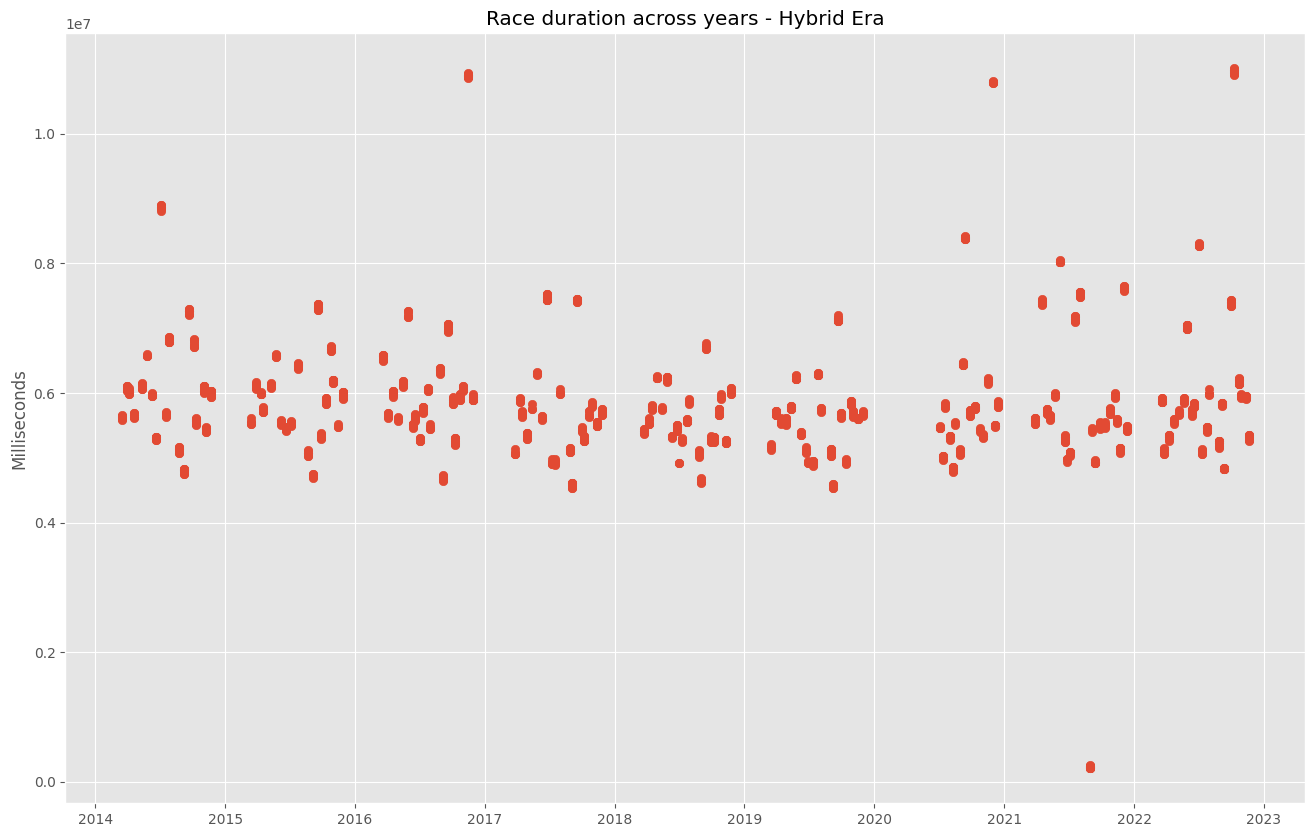

In [17]:
#create hybrid era subset and plot race durations over time
hybrid_dur = df_racedur[df_racedur.year > 2013]
plt.scatter(hybrid_dur.date,hybrid_dur.milliseconds)
plt.title('Race duration across years - Hybrid Era')
plt.ylabel('Milliseconds')

The race durations have improved slightly throughout the Hybrid Era. A new, bigger rule change happened in 2021, where the race car design changed. Therefore it is interesting to see how from 2014 to and including 2020 the race durations vary less from year to year. This is because the constructors improve their designs, being inspired by each other - and often the grid adapts to a "prefered design" that is considered to perform best. From 2014-2020 the prefered design was created by Mercedes. In 2021 and 2022, it seems Red Bull and Ferrari have beaten Mercedes with their designs thus far.

As race duration is a possible target variable, let's examine its distribution in both the entire history of Formula 1 and only in the Hybrid Era.

Text(0.5, 0, 'Milliseconds')

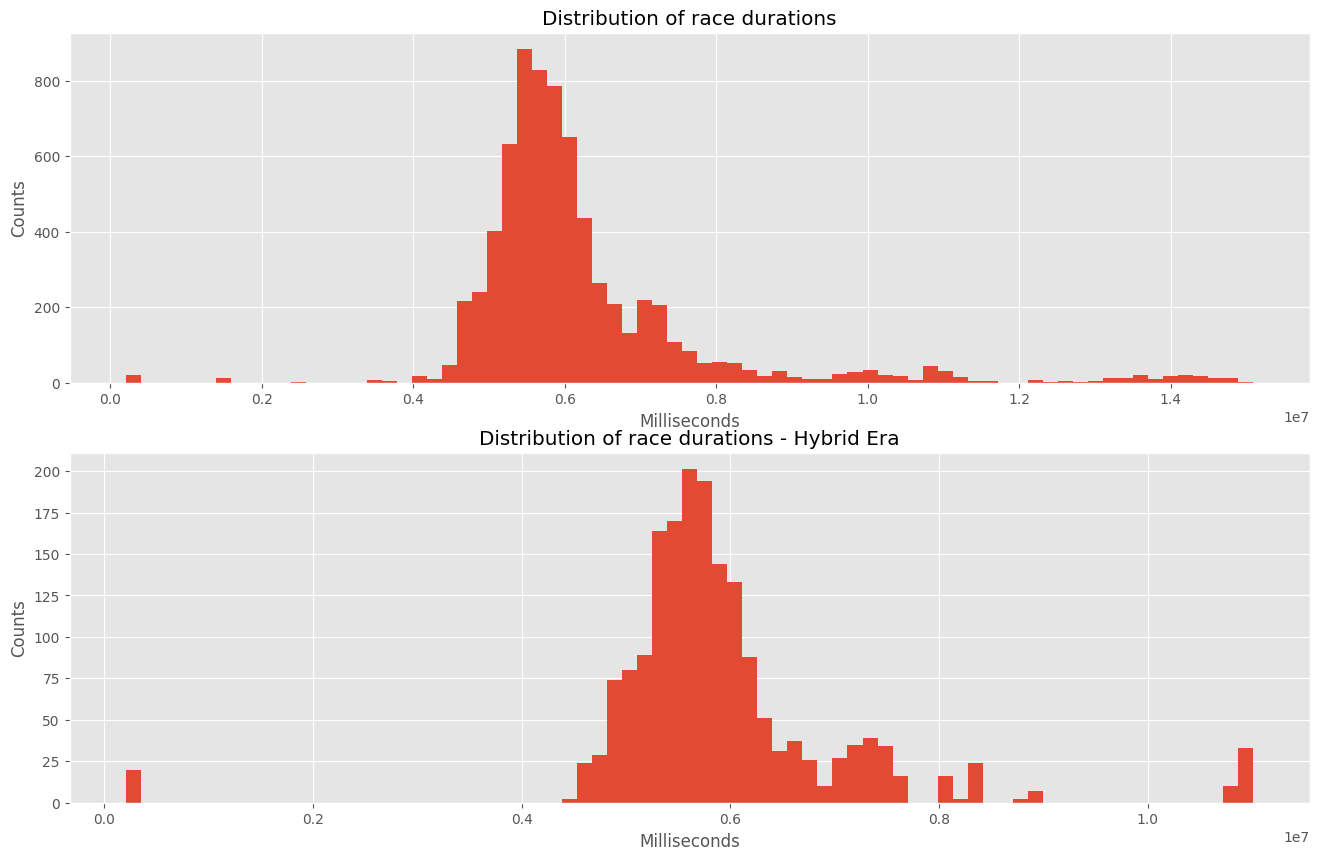

In [18]:
#plot histograms of race durations
plt.subplot(2, 1, 1)
df_racedur.milliseconds.hist(bins = 75)
plt.title('Distribution of race durations')
plt.ylabel('Counts')
plt.xlabel('Milliseconds')

plt.subplot(2, 1, 2)
hybrid_dur.milliseconds.hist(bins = 75)
plt.title('Distribution of race durations - Hybrid Era')
plt.ylabel('Counts')
plt.xlabel('Milliseconds')

In both cases, the distribution resembles a gaussian distribution, although it is less skewed in the Hybrid Era.

## 5. Fastest Lap Time in Race

Another intersting variable is the fastest lap for every driver in a race. Let's take a look at how this has evolved over time. Let's examine the fastest lap time in a race for all drivers and only for the race winners across the years.

In [19]:
#create fastest lap dataframe for both all years and the hybrid era
fastest_lap = df_racedur[df_racedur['fastestLapTime'] != '\\N']
fastest_lap['fastestLap_sec'] = fastest_lap['fastestLapTime'].apply(lambda x: int(x.split(':')[0])*60 + float(x.split(':')[1]))

hybrid_fastest_lap = hybrid_dur[hybrid_dur['fastestLapTime'] != '\\N']
hybrid_fastest_lap['fastestLap_sec'] = hybrid_fastest_lap['fastestLapTime'].apply(lambda x: int(x.split(':')[0])*60 + float(x.split(':')[1]))

#create subsets with only race winners
lap_winner = fastest_lap[fastest_lap.position == "1"]
hybrid_lap_winner = hybrid_fastest_lap[hybrid_fastest_lap.position == "1"]

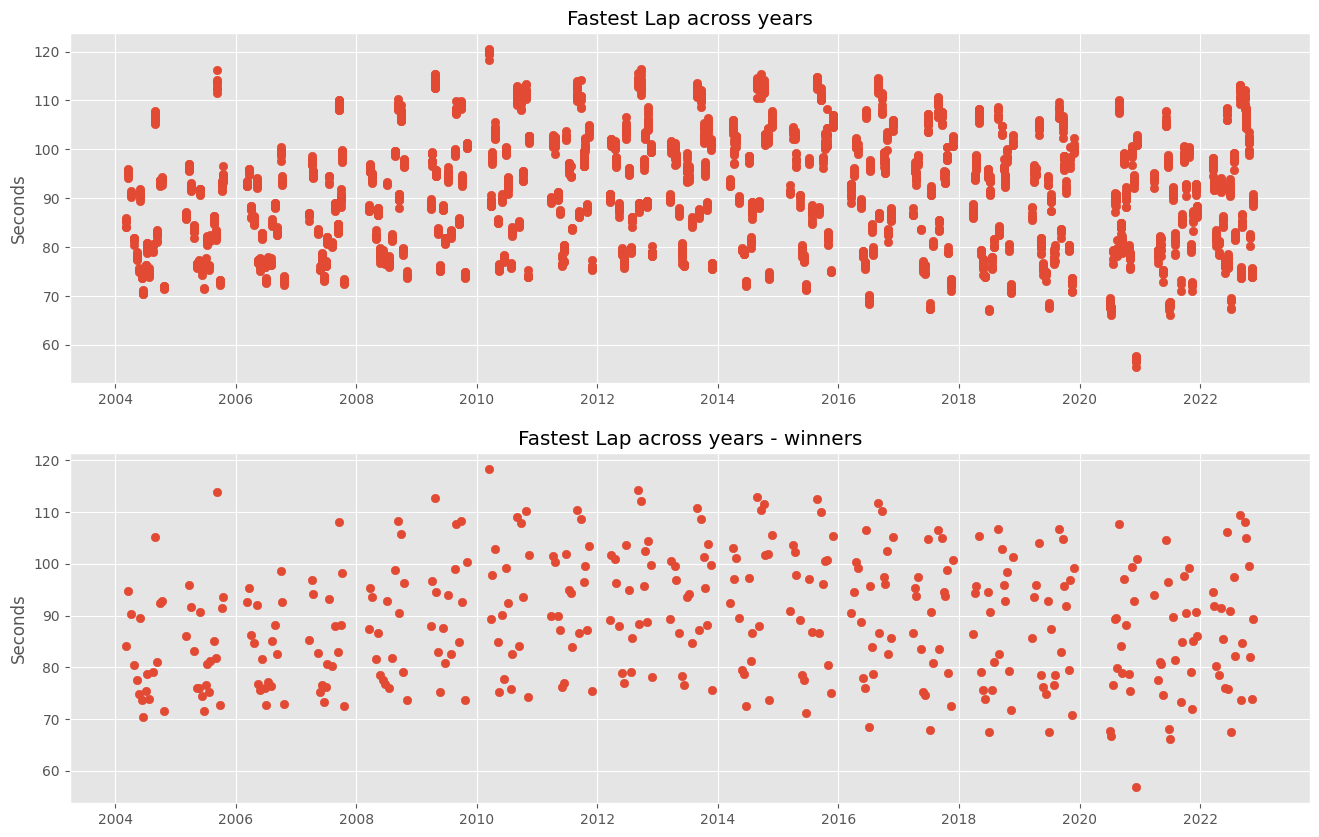

In [20]:
#plot fastest lap across years for all drivers and for winners only
plt.subplot(2, 1, 1)
plt.scatter(fastest_lap.date,fastest_lap.fastestLap_sec)
plt.title('Fastest Lap across years')
plt.ylabel('Seconds')

plt.subplot(2, 1, 2)
plt.scatter(lap_winner.date,lap_winner.fastestLap_sec)
plt.title('Fastest Lap across years - winners')
plt.ylabel('Seconds')

plt.show()

Since data started being collected in 2004, the fastest lap for every driver in each race has evolved slightly. This is the case for all drivers as well as only the race winners - the same tendency can be observed of a slight increase in lap duration followed by a decrease in lap durations again. In fact, turning point is around 2014, where the Hybrid Era began.

Let's cut away the years before the Hybrid Era:

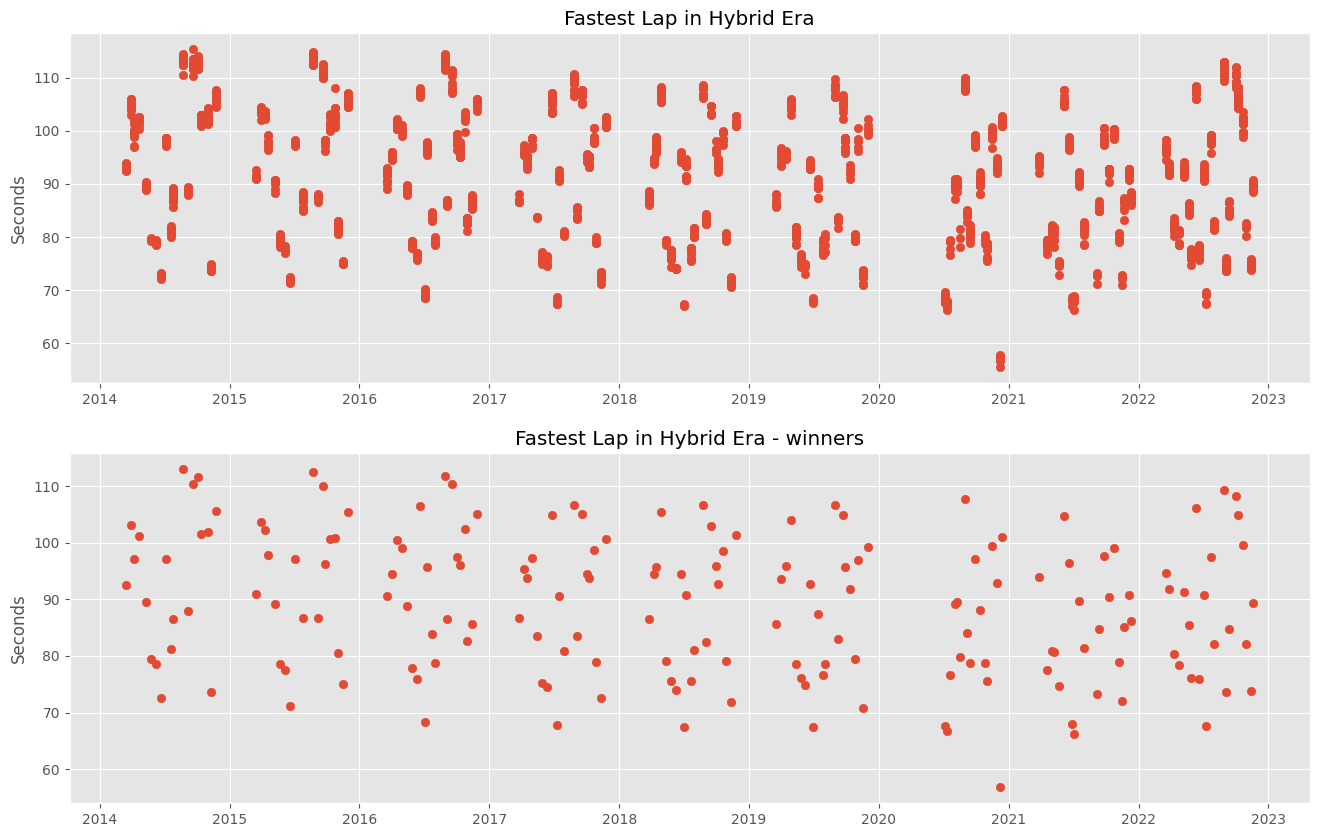

In [21]:
#plot fastest lap in hybrid era for all drivers and for winners only
plt.subplot(2, 1, 1)
plt.scatter(hybrid_fastest_lap.date,hybrid_fastest_lap.fastestLap_sec)
plt.title('Fastest Lap in Hybrid Era')
plt.ylabel('Seconds')

plt.subplot(2, 1, 2)
plt.scatter(hybrid_lap_winner.date,hybrid_lap_winner.fastestLap_sec)
plt.title('Fastest Lap in Hybrid Era - winners')
plt.ylabel('Seconds')

plt.show()

Again, the tendency is similar for all drivers as well as for only winners. From 2014 and on the fastest race laps have become slightly quicker.

## 6. Drivers & Constructors

Thus far, we have focused on the change in race car performance across years. We have seen where different circuits are located. But a key element of Formula 1 is also the drivers - in addition to the driver/constructor combination. The constructors build cars, and they try to build the fastest car - but to win they also need a good driver. The drivers need a fast car to win and to showcase their skills, so every driver seeks the best constructor, and each constructor seeks the best driver in their price range. Some combinations of teams and drivers have proven more competitive than others - like Hamilton at Mercedes or Schumacher at Ferrari. Let's take a look at the most winning drivers in Formula 1:

In [22]:
#find race winners and create subset
df_winners = df_drivers.merge(df_results, on='driverId', how='inner',suffixes=('_driver', '_result'))
race_winners = pd.Series(df_winners[df_winners.positionOrder == 1]['code'].value_counts())[1:]

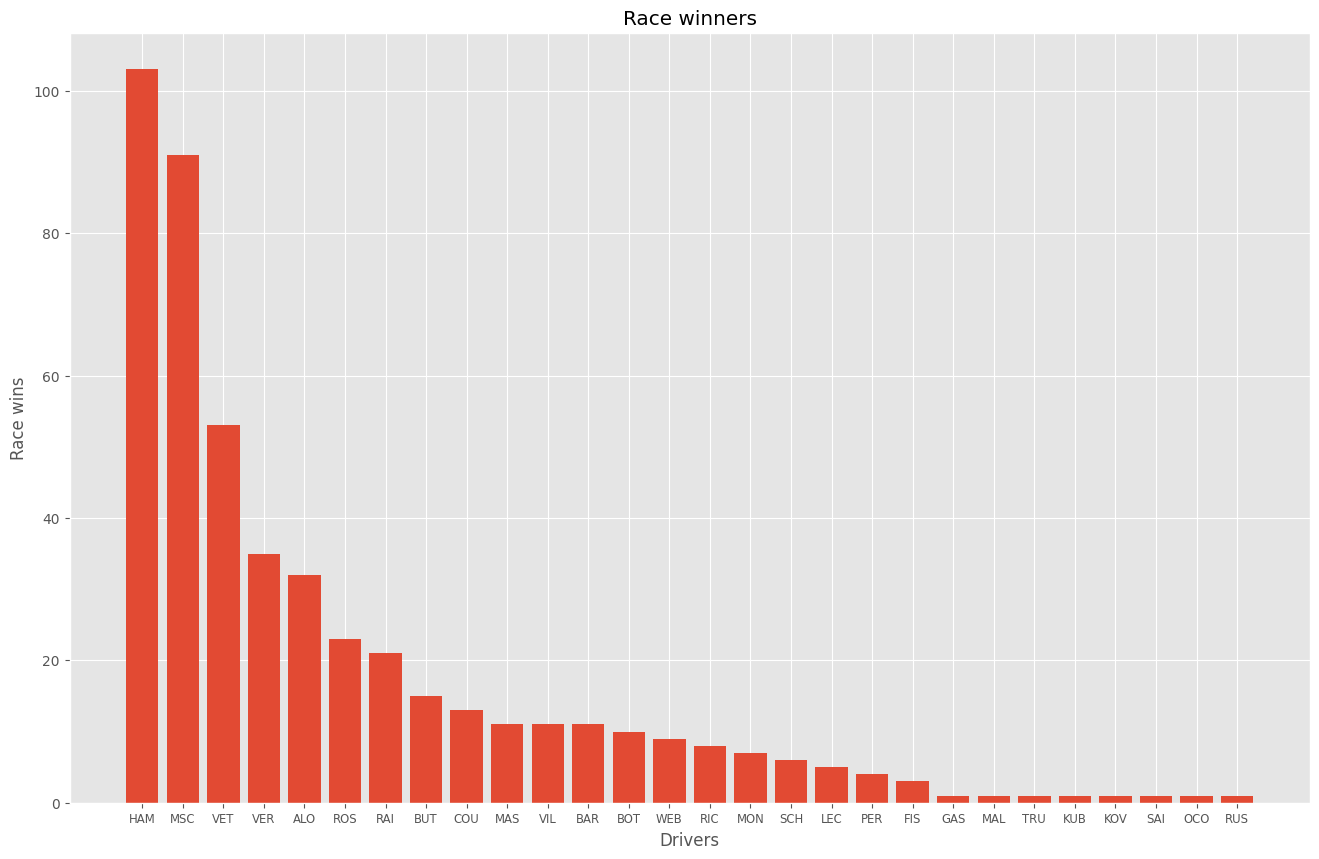

In [23]:
#plot number of race wins per driver
plt.bar(range(len(race_winners)), race_winners.values, align='center')
plt.xticks(range(len(race_winners)), race_winners.index.values, size='small')
plt.title('Race winners')
plt.xlabel('Drivers')
plt.ylabel('Race wins')
plt.show()

The driver with most race wins is Lewis Hamilton with 103 race wins. He has driven for McLaren and Mercedes. The second most race-winning driver is Michael Schumacher - he has driven for Jordan, Benetton, Ferrari and Mercedes. The third most race-winning driver is Sebastian Vettel but he only has about half the amount of race wins as Hamilton - and he has raced for many more teams than Hamilton; BMW Sauber, Toro Rosso, Red Bull, Ferrari, and Aston Martin. So both the skills of the driver and the team affects a driver's ability to win races.

In fact, let's examine which driver has driven for most teams in the Hybrid Era.

In [24]:
#compute driver team combinations
driver_team_combo = df_results.merge(df_races[['raceId','year']], on=['raceId'], how='inner',suffixes=('_result', '_race'))
driver_team_combo = driver_team_combo.merge(df_constructors[['constructorId','name']], on=['constructorId'], how='inner',suffixes=('_result', '_constructor'))
driver_team_combo = driver_team_combo.merge(df_drivers[['driverId','code']], on=['driverId'], how='inner',suffixes=('_result', '_driver'))
driver_team_combo = driver_team_combo.drop_duplicates(subset=['year','name','driverId'])[['year','name','code','driverId']]
driver_team_combo_2014on = driver_team_combo[driver_team_combo.year > 2013]
driver_team_combo_2014on = pd.Series(driver_team_combo_2014on.drop_duplicates(subset=['name','driverId'])['code'].value_counts()[1:])

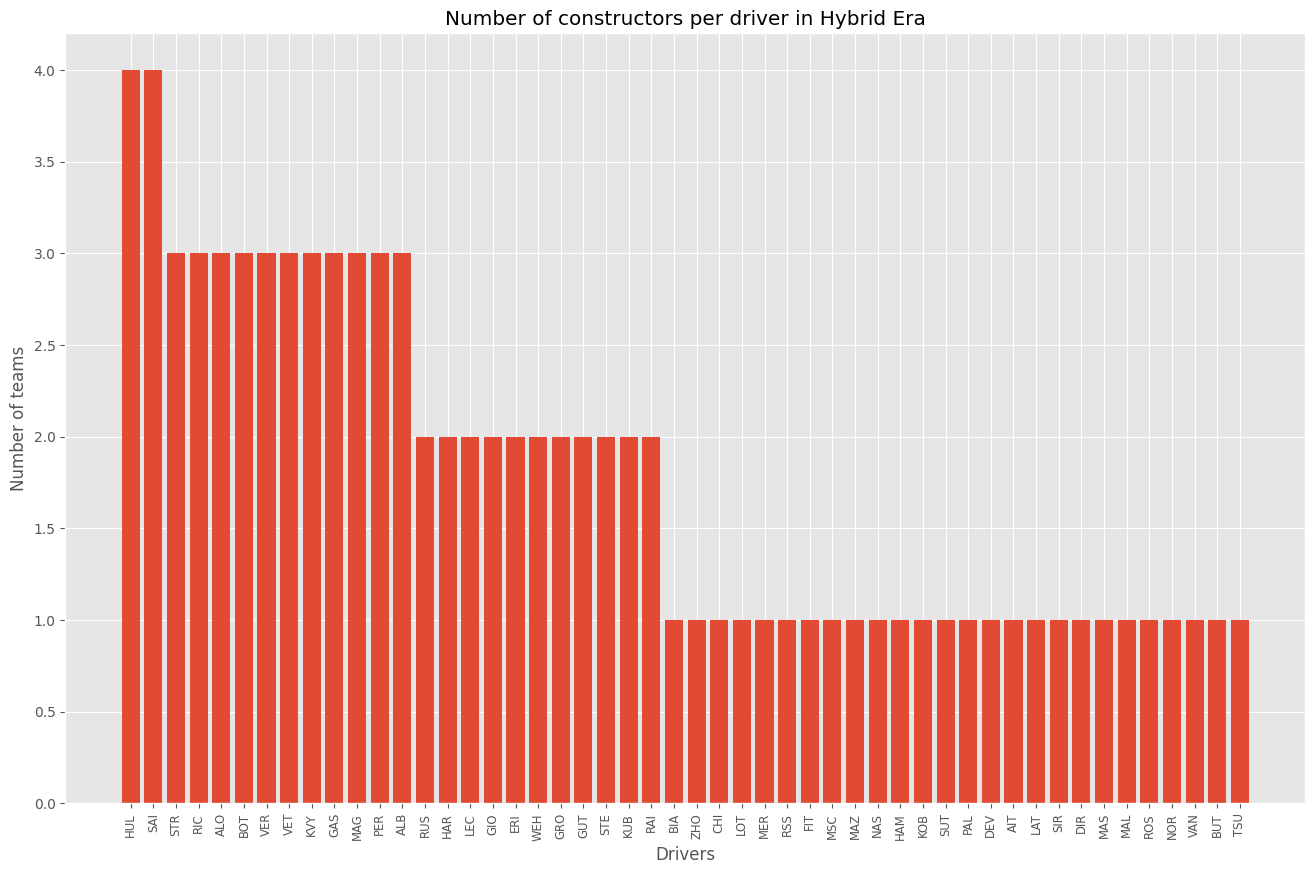

In [25]:
#plot number of teams each driver has been on
plt.bar(range(len(driver_team_combo_2014on)), driver_team_combo_2014on.values, align='center')
plt.xticks(range(len(driver_team_combo_2014on)), driver_team_combo_2014on.index.values, size='small')
plt.title('Number of constructors per driver in Hybrid Era')
plt.xlabel('Drivers')
plt.ylabel('Number of teams')
plt.xticks(rotation=90)
plt.show()

In the Hybrid Era, the driver with the most team switches is Hulkenberg and Sainz, who each have driven for 4 teams. Different drivers can drive for many different teams as they have time limited contracts. Some driver-constructor combinations extend their collaboration for a long time, like Hamilton and Mercedes. But every year, Formula 1 has what they call a "silly season" where all the contracts are negotiated for drivers without a contract the following year - and this is where drivers get the opportunity to switch teams.

Let's try to examine who has dominated the Hybrid Era in the driver's world championship:

In [26]:
#merge driver standings and drivers
df_champ = df_driverstandings.merge(df_races, on='raceId', how='inner',suffixes=('_champ', '_race'))
df_champ = df_champ.merge(df_drivers, on='driverId', how='inner',suffixes=('_results', '_driver'))
#df_champ.date = pd.to_datetime(df_champ.date)

# find top 3 for each race from 2014
winners = df_champ[df_champ.position < 4]
winners = winners[winners.year > 2013]

#find final top 3 in each season 2014-2021
final_race = winners.groupby(by = ['year'])['round'].max().to_frame(name = 'round').reset_index()
final_race = final_race[final_race.year !=2023]
winners_top3 = winners.merge(final_race, on=['year','round'], how='inner',suffixes=('_winner', '_round'))

In [27]:
#plot bump chart
list_dist = list(set(winners_top3['code']))
pal = list(sns.color_palette(palette=cc.glasbey,
                             n_colors=len(list_dist)).as_hex())
dict_color = dict(zip(list_dist, pal))

fig = px.line(winners_top3, x = 'year', y = 'position',
              color = 'code',
              color_discrete_map= dict_color, 
              markers=True,
              hover_name = 'surname')
fig.update_traces(marker=dict(size=11))
fig.update_yaxes(autorange='reversed', title='Rank',
                 visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False) )
fig.show()

From 2014 until 2022, the world champion has come from Mercedes - Lewis Hamilton has won 6 times and Nico Rosberg has won once. Both drivers won with Mercedes. In 2021 and 2022 Max Verstappen won with Red Bull. In the Hybrid Era, it has been Mercedes, Red Bull, Ferarri, and McLaren in particular that has been the top constructors:

In [29]:
#merge constructor standings and constructors
df_conchamp = df_constructorstandings.merge(df_races, on='raceId', how='inner',suffixes=('_champ', '_race'))
df_conchamp = df_conchamp.merge(df_constructors, on='constructorId', how='inner',suffixes=('_results', '_constructor'))

# find top 3 for each race from 2014
con_winners = df_conchamp[df_conchamp.position < 4]
con_winners = con_winners[con_winners.year > 2013]

#find final top 3 in each season 2014-2022
final_race_con = con_winners.groupby(by = ['year'])['round'].max().to_frame(name = 'round').reset_index()
final_race_con = final_race_con[final_race_con.year !=2023]
con_winners_top3 = con_winners.merge(final_race, on=['year','round'], how='inner',suffixes=('_winner', '_round'))

In [30]:
#plot bump chart
list_dist = list(set(con_winners_top3['name_constructor']))
pal = list(sns.color_palette(palette='husl',
                             n_colors=len(list_dist)).as_hex())
dict_color = dict(zip(list_dist, pal))
fig = px.scatter(con_winners_top3, x = 'year', y = 'position',
              color = 'name_constructor',
              color_discrete_map= dict_color)
fig.update_traces(marker=dict(size=25))
fig.update_yaxes(autorange='reversed', title='Rank',
                 visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False) )
fig.show()

## 7. A Look at Season 2018
To showcase how the top 10 in the driver's championship change througout a season - let's look at 2018.

In [32]:
#create subset of data with ranks
df_rank = df_results.merge(df_races, on='raceId', how='inner',suffixes=('_results', '_race'))
df_rank = df_rank.merge(df_drivers, on='driverId', how='inner',suffixes=('_results', '_driver'))
df_rank.date = pd.to_datetime(df_rank.date)

#focus on 2018
rank_2018 = df_rank[df_rank.year == 2018]
rank_2018 = rank_2018[rank_2018.positionOrder < 11]

In [33]:
#extract color palette
list_dist = list(set(rank_2018['code']))
pal = list(sns.color_palette(palette=cc.glasbey,
                             n_colors=len(list_dist)).as_hex())
dict_color = dict(zip(list_dist, pal))

In [34]:
#plot bump chart
fig = px.line(rank_2018, x = 'date', y = 'positionOrder',
              color = 'code',
              color_discrete_map= dict_color, 
              markers=True,
              hover_name = 'surname')
fig.update_traces(marker=dict(size=11))
fig.update_yaxes(autorange='reversed', title='Rank',
                 visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False) )
fig.show()

Hamilton ended up winning the 2018 championship but it can be seen how, espeically in the beginning, the ranks swap around. It is also seen how at the very last race, Verstappen went from being second in the championship to ending as third, beaten by Vettel.